In [ ]:
!pip install pandas scikit-learn xgboost matplotlib seaborn


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define required features
required_features = ['N', 'P', 'K', 'pH', 'rainfall', 'temperature']


In [3]:
# Load training and test data
train_df = pd.read_csv("/content/Train Dataset.csv")
test_df = pd.read_csv("/content/Test Dataset.csv")

In [4]:
# Drop unnecessary columns
train_df = train_df.drop(columns=[col for col in train_df.columns if col not in required_features + ['Crop']])
if "Unnamed: 0" in train_df.columns:
    train_df = train_df.drop("Unnamed: 0", axis=1)

if "Unnamed: 0" in test_df.columns:
    test_df = test_df.drop("Unnamed: 0", axis=1)

In [5]:
# Split features and label
X_train = train_df[required_features]
y_train = train_df["Crop"]

In [6]:
# Encode label
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [7]:
# Clean test data
X_test = test_df.copy()

In [8]:
# Drop label column if present in test
if "Crop" in X_test.columns:
    X_test = X_test.drop("Crop", axis=1)

In [9]:
# Drop extra columns
X_test = X_test[[col for col in X_test.columns if col in required_features]]


In [10]:
# Reorder to match training columns
X_test = X_test[required_features]

In [11]:
# Confirm columns match
print("✅ X_test columns:", list(X_test.columns))


✅ X_test columns: ['N', 'P', 'K', 'pH', 'rainfall', 'temperature']


In [12]:
# Define models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)


In [13]:
# Ensemble model
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb)
], voting='soft')


In [14]:
# Train model
ensemble.fit(X_train, y_train_enc)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_pol...e,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [15]:
# Predict on test data
y_pred_enc = ensemble.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred_enc)


In [16]:
# Print results
print("\n🔍 Predicted Crops for Test Data:")
pred_df = test_df.copy()
pred_df["Predicted Crop"] = y_pred_labels
print(pred_df[["Predicted Crop"]].head())


🔍 Predicted Crops for Test Data:
  Predicted Crop
0         barley
1      sunflower
2    sweetpotato
3           rice
4       soyabean


In [17]:
# Save predictions to CSV
pred_df.to_csv("crop_predictions.csv", index=False)
print("\n📁 Predictions saved to 'crop_predictions.csv'.")


📁 Predictions saved to 'crop_predictions.csv'.



🎯 Accuracy on test set: 95.50%

📊 Classification Report:
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00       507
      barley       1.00      1.00      1.00       654
 bittergourd       1.00      1.00      1.00        11
   blackgram       1.00      1.00      1.00        11
 blackpepper       1.00      1.00      1.00       119
 bottlegourd       1.00      1.00      1.00        13
     brinjal       1.00      1.00      1.00        55
     cabbage       1.00      1.00      1.00        26
    cardamom       1.00      1.00      1.00        54
 cauliflower       1.00      1.00      1.00        23
   coriander       1.00      1.00      1.00       473
      cotton       1.00      1.00      1.00       613
    cucumber       1.00      1.00      1.00        20
   drumstick       1.00      1.00      1.00        17
      garlic       1.00      1.00      1.00       415
      grapes       1.00      1.00      1.00        19
   horsegram       1.00

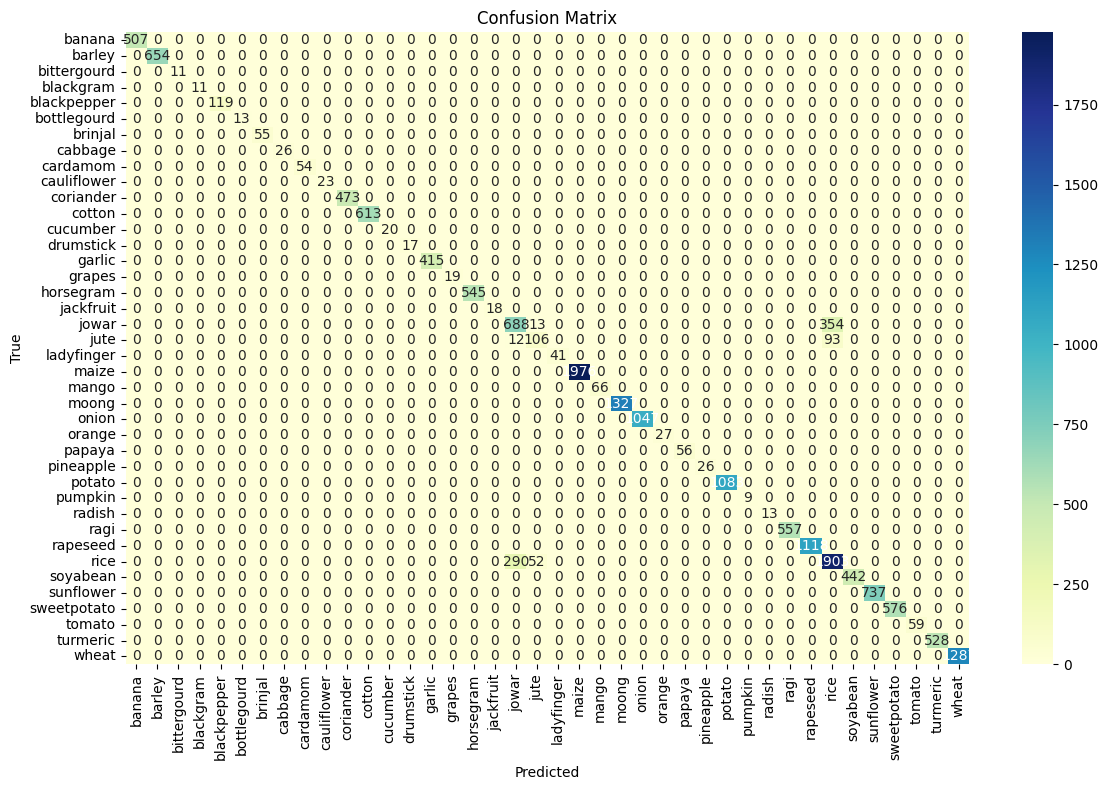

In [18]:
# Optional: Evaluate if test has true labels
if 'Crop' in test_df.columns:
    y_test_true = le.transform(test_df['Crop'])
    acc = accuracy_score(y_test_true, y_pred_enc)
    print(f"\n🎯 Accuracy on test set: {acc * 100:.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(y_test_true, y_pred_enc, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test_true, y_pred_enc)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [19]:
# Recommendation function
def recommend_crop(N, P, K, pH, rainfall, temperature):
    sample = pd.DataFrame([[N, P, K, pH, rainfall, temperature]], columns=required_features)
    pred = ensemble.predict(sample)
    return le.inverse_transform(pred)[0]

In [20]:
# Example usage
print("\n🌱 Example Recommendation:", recommend_crop(100, 40, 40, 6.5, 200, 25))


🌱 Example Recommendation: jowar


In [21]:
import joblib
joblib.dump(ensemble, "crop_model.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

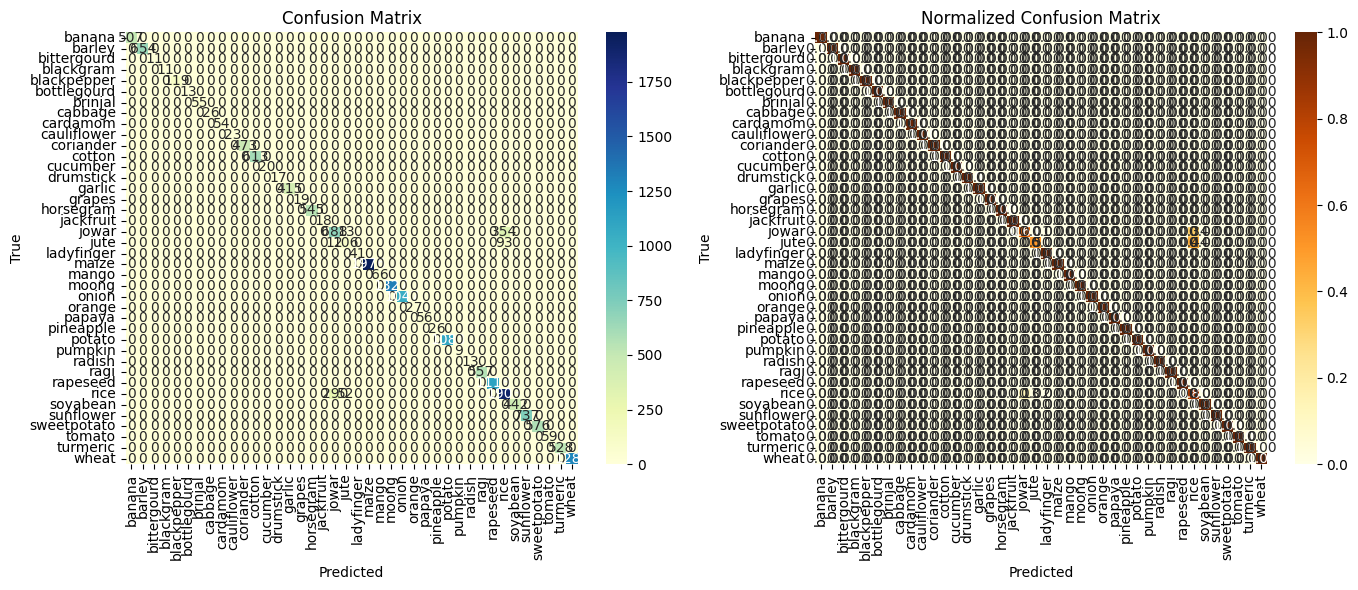

/tmp/ipython-input-26-2993513613.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=f1_scores, palette="viridis")


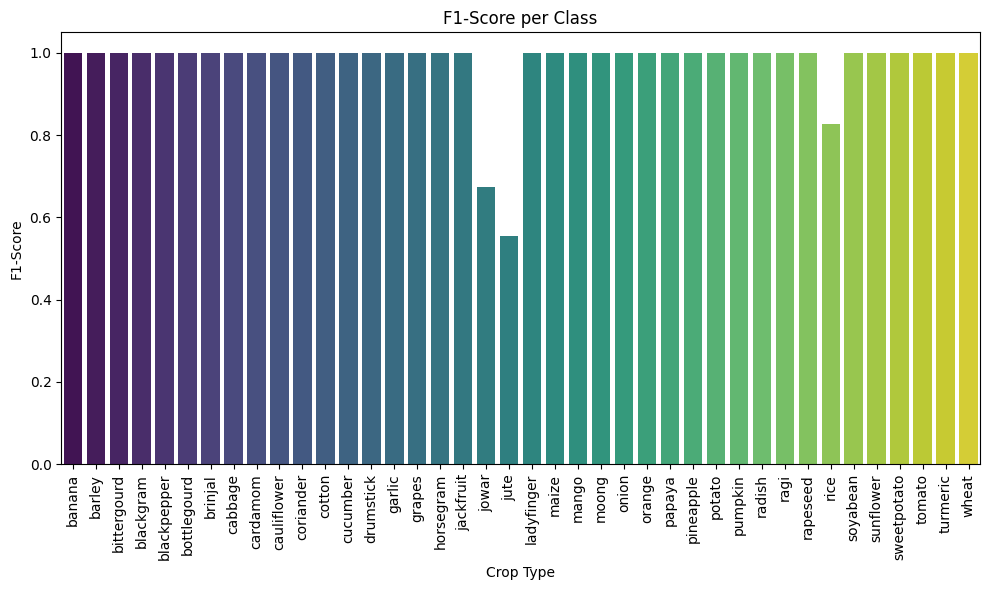

In [26]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Optional: Evaluate if test has true labels
if 'Crop' in test_df.columns:
    y_test_true = le.transform(test_df['Crop'])

    # Basic metrics
    acc = accuracy_score(y_test_true, y_pred_enc)
    report = classification_report(y_test_true, y_pred_enc, target_names=le.classes_, output_dict=True)

    # Confusion matrix (absolute and normalized)
    cm = confusion_matrix(y_test_true, y_pred_enc)
    cm_norm = confusion_matrix(y_test_true, y_pred_enc, normalize='true')

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='YlOrBr', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Bar plot of F1-scores
    f1_scores = [report[label]['f1-score'] for label in le.classes_]
    supports = [report[label]['support'] for label in le.classes_]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=le.classes_, y=f1_scores, palette="viridis")
    plt.xticks(rotation=90)
    plt.title("F1-Score per Class")
    plt.ylabel("F1-Score")
    plt.xlabel("Crop Type")
    plt.tight_layout()
    plt.show()

    # Feature importance plot (if model has feature_importances_)
    if hasattr(ensemble.estimators[0], 'feature_importances_'):
        importances = ensemble.estimators[0].feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = X_test.columns

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[indices], y=feature_names[indices], palette="coolwarm")
        plt.title("Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()





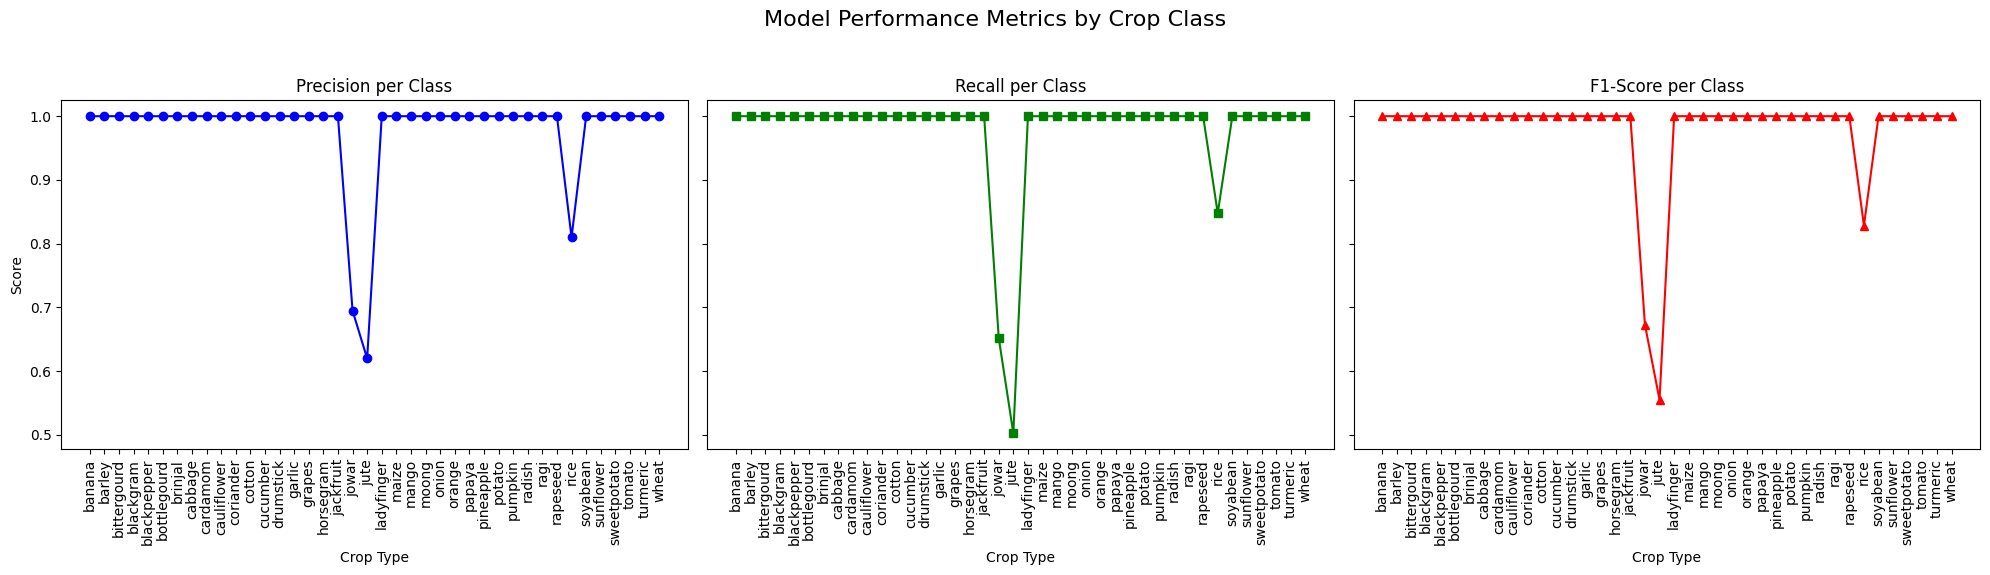

In [30]:
import matplotlib.pyplot as plt

# Ensure report_df is prepared (if not already done)
report_dict = classification_report(y_test_true, y_pred_enc, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
report_df['Class'] = report_df.index

# Create 3 subplots for Precision, Recall, and F1-Score
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Precision
axs[0].plot(report_df['Class'], report_df['precision'], marker='o', color='blue')
axs[0].set_title('Precision per Class')
axs[0].set_xlabel('Crop Type')
axs[0].set_ylabel('Score')
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(False)

# Recall
axs[1].plot(report_df['Class'], report_df['recall'], marker='s', color='green')
axs[1].set_title('Recall per Class')
axs[1].set_xlabel('Crop Type')
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(False)

# F1-Score
axs[2].plot(report_df['Class'], report_df['f1-score'], marker='^', color='red')
axs[2].set_title('F1-Score per Class')
axs[2].set_xlabel('Crop Type')
axs[2].tick_params(axis='x', rotation=90)
axs[2].grid(False)

plt.suptitle('Model Performance Metrics by Crop Class', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
plt.show()


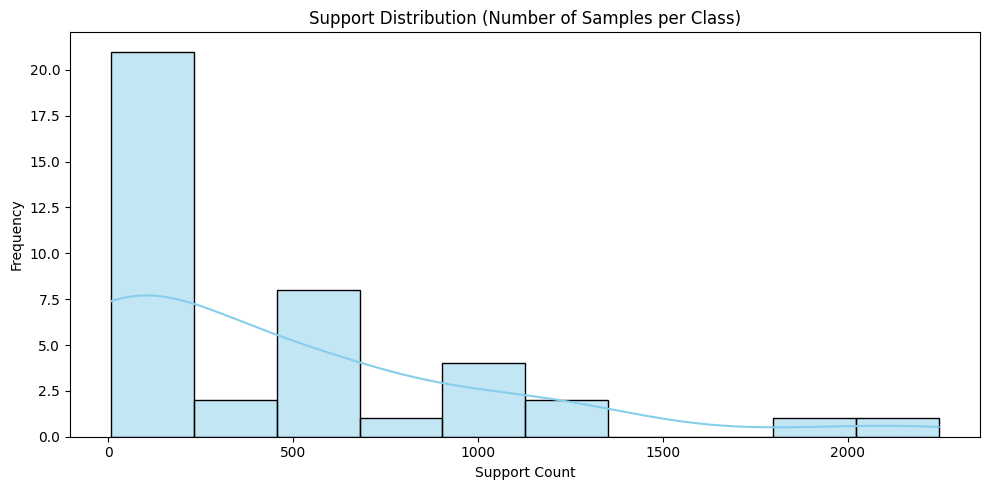

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(report_df['support'], bins=10, kde=True, color='skyblue')
plt.title('Support Distribution (Number of Samples per Class)')
plt.xlabel('Support Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


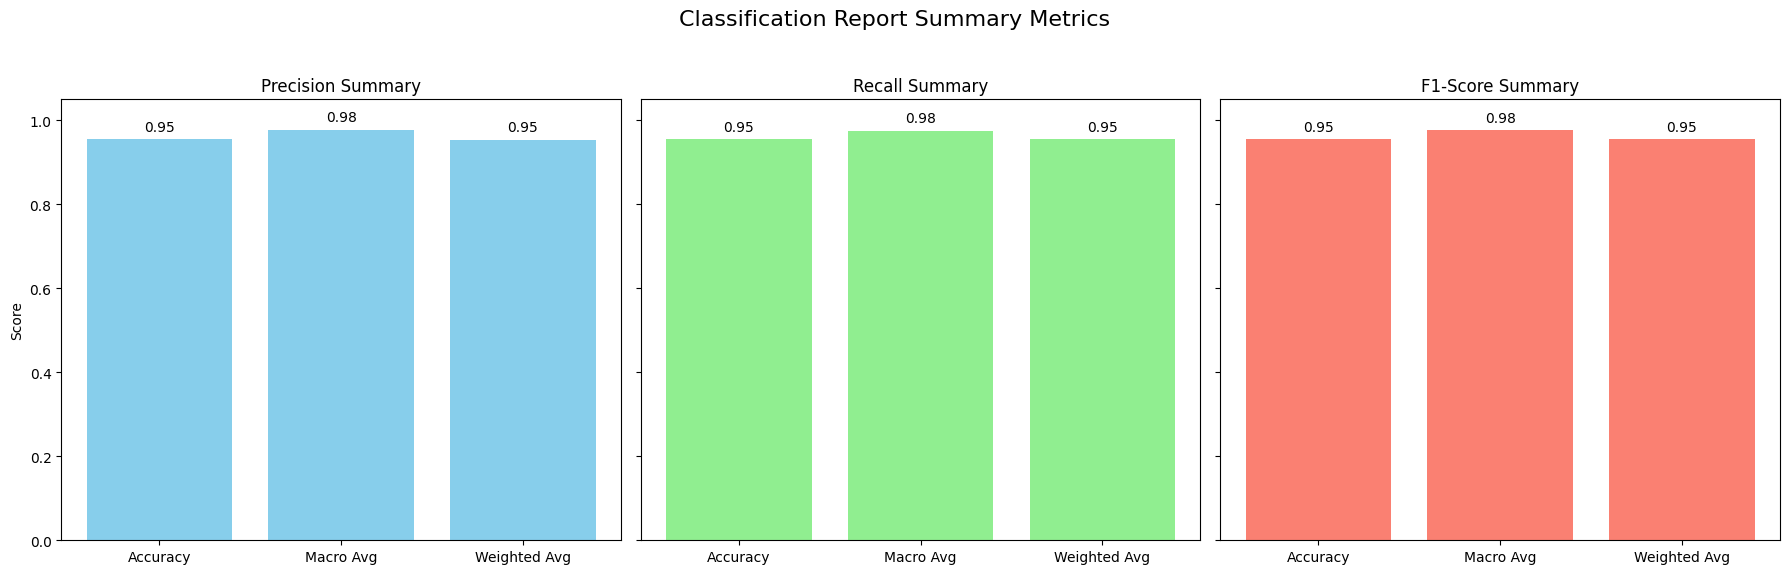

In [34]:
# Step 2: Extract summary data (accuracy, macro avg, weighted avg)
summary_labels = ['Accuracy', 'Macro Avg', 'Weighted Avg']
precision = [report_dict['accuracy'], report_dict['macro avg']['precision'], report_dict['weighted avg']['precision']]
recall = [report_dict['accuracy'], report_dict['macro avg']['recall'], report_dict['weighted avg']['recall']]
f1 = [report_dict['accuracy'], report_dict['macro avg']['f1-score'], report_dict['weighted avg']['f1-score']]

# Step 3: Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Precision Plot
axs[0].bar(summary_labels, precision, color='skyblue')
axs[0].set_title('Precision Summary')
axs[0].set_ylim(0, 1.05)
axs[0].set_ylabel('Score')
for i, v in enumerate(precision):
    axs[0].text(i, v + 0.02, f"{v:.2f}", ha='center')

# Recall Plot
axs[1].bar(summary_labels, recall, color='lightgreen')
axs[1].set_title('Recall Summary')
axs[1].set_ylim(0, 1.05)
for i, v in enumerate(recall):
    axs[1].text(i, v + 0.02, f"{v:.2f}", ha='center')

# F1-Score Plot
axs[2].bar(summary_labels, f1, color='salmon')
axs[2].set_title('F1-Score Summary')
axs[2].set_ylim(0, 1.05)
for i, v in enumerate(f1):
    axs[2].text(i, v + 0.02, f"{v:.2f}", ha='center')

# Final layout
plt.suptitle('Classification Report Summary Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()